# Business Questions:

    - How may Airbnb landlords get the best price?

    - Is there any features that Airbnb landlords may consider as less important, to get the best price?

    - How may Airbnb landlords get good reviews?

# A Look at the Data
In order to get a better understanding of the data I will be looking at, I need to know the characteristics of the dataset.
First, I read in the data and necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
%matplotlib inline
from sklearn.model_selection import train_test_split


In [2]:
# Gather data:
reviews = pd.read_csv('reviews.csv')
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')

In [3]:
# Assessing the data:
print("Shape of dataframes:\n"
      "\nDataframe: rows, columns",
      "\nreviews:", "", reviews.shape,
      "\ncalendar:", calendar.shape,
      "\nlistings:", listings.shape)

Shape of dataframes:

Dataframe: rows, columns 
reviews:  (84849, 6) 
calendar: (1393570, 4) 
listings: (3818, 92)


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [5]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [6]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [7]:
# Manual assessment in Google sheets made me aware of that the data in the column "amenities" needs to be altered.
# I want to extract some values and make them into new features:
listings['aircondition'] = listings.amenities.str.contains('air condition|air conditioning|air conditioned', case=False)
listings['tv'] = listings.amenities.str.contains('tv', case=False)
listings['parking'] = listings.amenities.str.contains('parking', case=False)
listings['internet'] = listings.amenities.str.contains('wifi|internet|wireless', case=False)

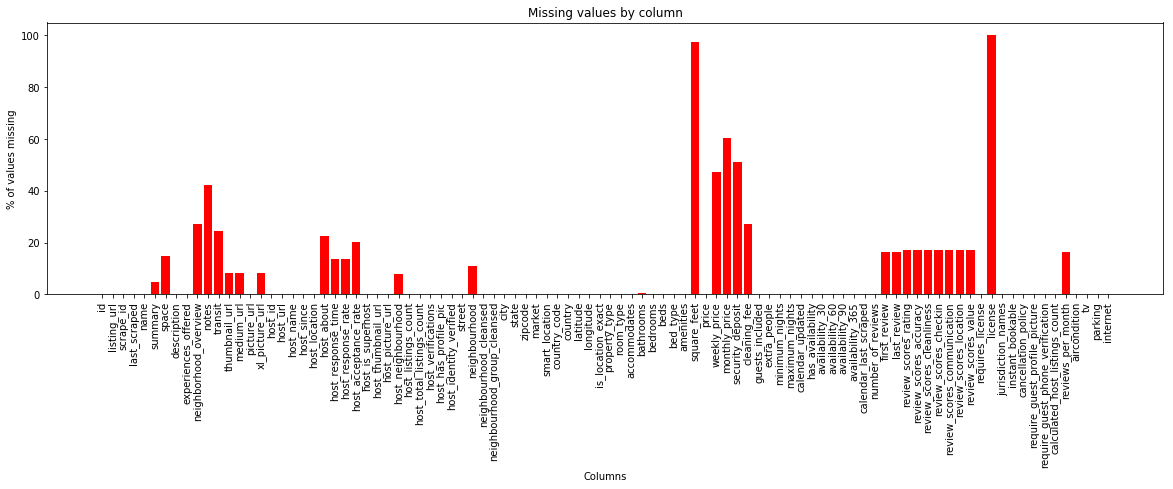

In [8]:
# Looking at missing values
missingpercentage = [(listings[series].isnull().sum()
                      /len(listings[series])) * 100 for series in list(listings)]
missing = [series for series in list(listings)]
fig, ax = plt.pyplot.subplots(figsize=(20,5))
plt.pyplot.title("Missing values by column")
plt.pyplot.xlabel("Columns")
plt.pyplot.ylabel("% of values missing")
plt.pyplot.bar(missing, missingpercentage, color='r')
plt.pyplot.xticks(rotation=90);

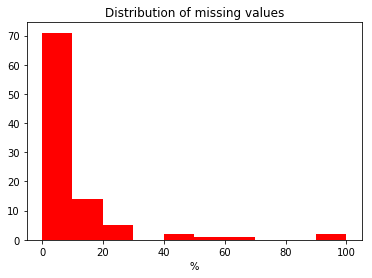

In [9]:
# Looking at the distribution of missing values in a histogram:
plt.pyplot.title("Distribution of missing values")
plt.pyplot.xlabel("%")
plt.pyplot.hist(missingpercentage, color='r');

In [10]:
# Dropping columns that have 20 % or more missing values:
def drop_outlier_columns(df, boundary):
    '''
    Function that identifies columns with 20 % or more outlier_columns.
    Input: DatFrame and boundary for share of missing values.
    Output: Two lists, that show respectively the columns and their count of missing values.
    '''
    outlier_columns=[]
    outlier_count=[]
    for i in list(df):
        if ((df[i].isnull().sum() / len(df[i])) > boundary):
            outlier_columns.append(i)
            outlier_count.append(df[i].isnull().sum())
    return outlier_columns, outlier_count

In [11]:
outlier_columns, outlier_count = drop_outlier_columns(listings, 0.2)
for i in zip(outlier_columns, outlier_count):
    print(i)

('neighborhood_overview', 1032)
('notes', 1606)
('transit', 934)
('host_about', 859)
('host_acceptance_rate', 773)
('square_feet', 3721)
('weekly_price', 1809)
('monthly_price', 2301)
('security_deposit', 1952)
('cleaning_fee', 1030)
('license', 3818)


In [12]:
listings.drop(outlier_columns, axis=1, inplace=True)

In [13]:
# I decided to drop a few more columns that I don't need for my further analysis:
listings.drop(['host_listings_count', 'scrape_id'], axis=1, inplace=True)

In [14]:
print("Shape of DataFrame listings after dropping outlier columns:",listings.shape)

Shape of DataFrame listings after dropping outlier columns: (3818, 83)


In [15]:
# Some of the columns need some altering before I can use them for analysis.
columns_to_make_numeric = ['price', 'extra_people', 'host_response_rate']
listings.price = listings.price.str.replace("$", "")
listings.price = listings.price.str.replace(",", "")
listings.price = pd.to_numeric(listings.price)
listings.extra_people = listings.extra_people.str.replace("$", "")
listings.extra_people = pd.to_numeric(listings.extra_people)
listings.host_response_rate = listings.host_response_rate.str.replace("%", "")
listings.host_response_rate = pd.to_numeric(listings.host_response_rate);

In [16]:
list(listings.select_dtypes(include=['object']));

In [17]:
columns_to_onehotencode = ['instant_bookable', 'host_is_superhost', 'host_identity_verified',
                           'property_type', 'cancellation_policy', 'room_type',
                           'host_response_type', 'bed_type', 'neighbourhood_group_cleansed']

In [18]:
drop_numerics = ['calculated_host_listings_count', 'review_scores_value', 'review_scores_location',
                 'review_scores_cleanliness', 'review_scores_accuracy', 'reviews_per_month',
                 'review_scores_checkin', 'review_scores_communication', 'id',
                 'host_id', 'latitude', 'longitude']
drop_objects = [i for i in list(listings.select_dtypes(include=['object']))
                if i not in columns_to_make_numeric + columns_to_onehotencode]

In [19]:
listings.drop(drop_numerics + drop_objects, axis=1, inplace=True)

In [20]:
# Checking the shape of the altered DataFrame:
print("Shape of DataFrame listings after dropping outlier columns:",listings.shape)

Shape of DataFrame listings after dropping outlier columns: (3818, 29)


#### Because the data in the DataFrame "listings" are to some extent redundant, I decided to drop quite a few features, as shown in the code above.

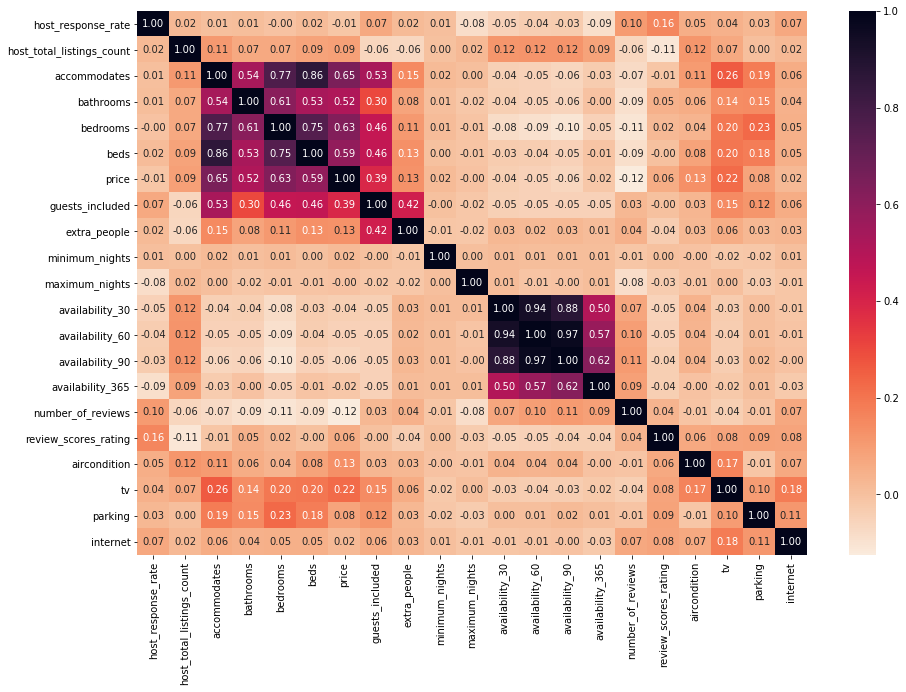

In [21]:
# I now want to see how the respective features in the DataFrame "listings" may correlate with each other, using a heatmap:
cmap = sns.cm.rocket_r
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f', cmap=cmap);

This heatmap shows that there are some features that correlate to a high degree. I drop features that correlate more than 70 %, to ensure that I keep only independent features.

In [22]:
correlates_most = ['bedrooms', 'beds', 'availability_60', 'availability_90','availability_365']
listings.drop(correlates_most, axis=1, inplace=True)

The feature 'accommodates' causes a bit of noise in the data caused by outliers. I therefore choose to drop rows that have a value greater than 7.

In [23]:
listings = listings[listings.accommodates <= 7]

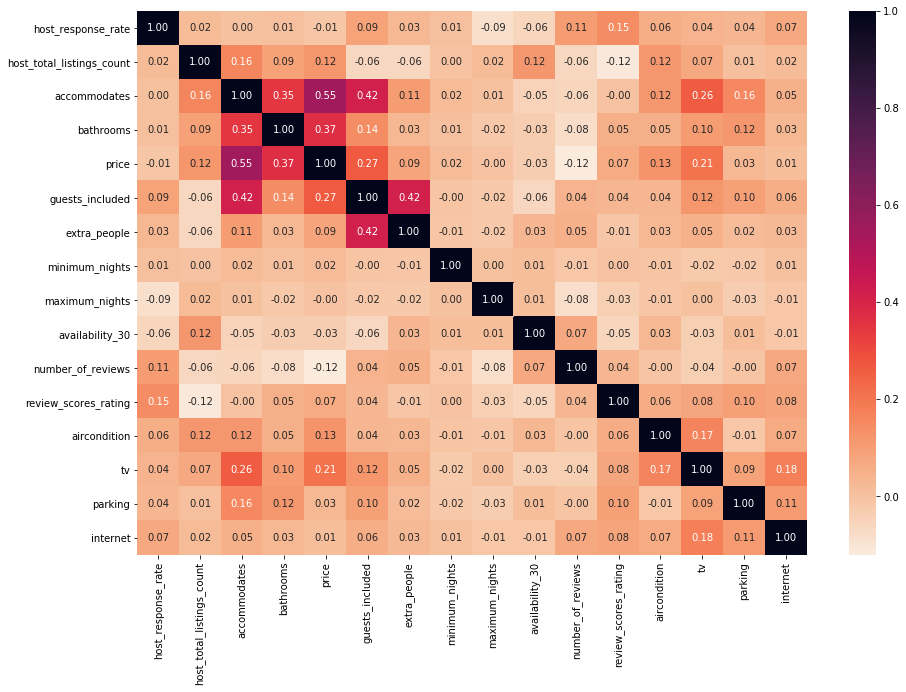

In [24]:
# Checking the heatmap again, after altering the data:
cmap = sns.cm.rocket_r
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f', cmap=cmap);

I also want to look at mean price by area, to show which areas in Seattle that tends to give the landlord the highest income:

In [25]:
neighbourhood = pd.DataFrame(listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False))
neighbourhood

,price
neighbourhood_group_cleansed,
Magnolia,157.750000
Downtown,149.360845
Queen Anne,141.039286
West Seattle,128.816216
Cascade,125.511628
Capitol Hill,118.064338
Central Area,114.924419
Ballard,113.342593
Other neighborhoods,110.994709


# How may Airbnb landlords get the best price?

From the heatmap above, I can see that the feature that correlates most with 'price' is 'accomodates'. From this I conclude that the number of people the appartment accomodates, is the main reason for getting a good price (from the landlords point of view). In addition to this, I also see that the mean price by neighbourhood varies a lot, and that the areas 'Magnolia' and 'Downtown' stands out at the top. So - if an Airbnb landlord has a listing in the "right" area, that also accommodates many guests, it is easier to get a higher price.

# Is there any features that Airbnb landlords may consider as less important, regarding the possibilities to get the best price?

I must admit that on beforehand I assumed that for example number of reviews would be a strong driver for price, but the heatmap indicates that this is not the case. Also, the minimum and maximum number of nights, as well as the the host respons rate, seems to have close to no impact on the pricing.

# How may Airbnb landlords get good reviews?

Looking at the heatmap again, I see that the host respons rating has the greatest impact when it comes to the review scores rating. Also, the number of reviews seems to assure the guests that the listing is good. Also, facilities like parking, tv, internet and bathrooms seems to influence the review positively. So - if an Airbnb landlord is good at giving responses to all enquiries from guests, and ensures that the appartment has a good standard, he should expect to be rewarded with good reviews.